In [30]:
from environment import ContextualEnvironment
from policies import KLUCBSegmentPolicy, RandomPolicy, ExploreThenCommitSegmentPolicy, EpsilonGreedySegmentPolicy, TSSegmentPolicy, LinearTSPolicy
import argparse
import json
import logging
import numpy as np
import pandas as pd
import time
from main import *


import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='darkgrid')

# Check Input
Looking at all the arguments that they need to perform the experiments

In [6]:
users_df = pd.read_csv("data/user_features.csv")
users_df.head()

,segment,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95
0,0,0.238895,1.559068,-1.492596,1.041009,2.040157,-2.914569,-0.743588,1.996449,-0.917277,...,-0.652371,-0.539649,0.189309,1.241029,0.767918,0.619496,4.004763,1.312571,-0.441051,0.898858
1,0,-0.268669,0.617194,-0.742123,1.677183,1.369093,-1.761860,-1.237178,1.276799,-2.924475,...,-0.060747,-1.312460,1.352925,1.251065,-1.624764,1.314707,2.027448,0.988371,-0.314620,1.583408
2,0,0.730793,1.615805,-0.540211,1.519919,0.474167,-2.616138,-1.168033,0.935113,-1.695110,...,-0.041504,0.456923,0.249240,0.878546,-0.787824,0.495024,1.752296,0.536689,-0.106732,0.516656
3,0,1.739003,1.546201,0.756946,2.240684,0.636115,-2.327271,-0.684070,1.323303,-3.234894,...,-1.372924,-1.172656,0.859095,1.026131,-0.410318,0.017065,-0.019434,0.003572,-0.638508,0.527119
4,0,0.060900,1.313942,-0.725372,0.953238,1.338075,-2.561447,-0.384696,1.040172,-1.201964,...,-0.920380,-0.417005,0.705332,0.741709,-1.598617,0.882672,2.023240,0.971578,-0.329573,0.629994


In [8]:
playlists_df = pd.read_csv("data/playlist_features.csv")
playlists_df.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,96
0,0.024252,-0.018636,0.012410,0.001008,0.044494,-0.004434,-0.005695,0.016350,0.019771,0.009652,...,0.013161,0.016955,0.005556,0.032493,0.023227,0.002972,0.012221,0.016389,-0.004321,-5.212592
1,-0.002291,-0.003837,0.027045,0.003238,0.027638,0.016666,-0.000113,-0.008341,0.026533,0.013764,...,0.012942,0.022978,-0.009120,0.002435,-0.000940,-0.020064,-0.020775,-0.003955,0.013123,-5.257495
2,0.009996,0.001475,0.016315,0.035247,0.014389,0.018869,0.005860,0.003982,-0.007220,0.017888,...,0.022230,0.036029,0.002565,0.020917,-0.008665,0.019002,-0.023298,0.049232,0.006402,-5.599810
3,0.001324,0.011623,0.007804,0.009014,0.006430,0.002558,0.008000,0.009254,0.003991,0.011995,...,0.009921,0.002054,0.006869,-0.004186,0.008501,0.006809,0.007393,0.003085,0.009104,-5.945421
4,-0.001324,0.015705,0.004648,0.005653,-0.003159,0.001712,0.021995,-0.013604,0.002715,0.003533,...,0.009651,0.005125,-0.002147,-0.005928,0.003602,0.003586,0.025799,0.015432,-0.003963,-6.525579


In [11]:
n_users = len(users_df)
n_playlists = len(playlists_df)
print('n_useres: %d \nn_playlists: %d'%(n_users,n_playlists))

n_useres: 974960 
n_playlists: 862


In [12]:
#default values as defined in main
n_recos = 12
print_every = 10

In [13]:
user_features = np.array(users_df.drop(["segment"], axis = 1))
user_features = np.concatenate([user_features, np.ones((n_users,1))], axis = 1)
playlist_features = np.array(playlists_df)
user_segment = np.array(users_df.segment)

In [16]:
cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)

In [23]:
policies_name = "random,ts-seg-naive".split(",")
policies = set_policies(policies_name, user_segment, user_features, n_playlists)
n_policies = len(policies)
n_users_per_round = 20000

/Users/christophbartmann/Library/Mobile Documents/com~apple~CloudDocs/New Macbook/Data Science/Design of Experiment/Exercise 2/carousel_reproduction/online_logistic_regression.py:26: RuntimeWarning: invalid value encountered in reciprocal
  self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)


In [24]:
n_rounds = 100
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

In [28]:
n_recos = 12
l_init = 3

In [81]:
seeds = [1,111,1111]
for k in range(3):
    print("run: %d"%k)
    start_time = time.time()
    for i in range(n_rounds):
        # Select batch of n_users_per_round users
        np.random.seed(seeds[k])
        user_ids = np.random.choice(range(n_users), n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        # Iterate over all policies
        for j in range(n_policies):
            # Compute n_recos recommendations
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            # Compute rewards
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids= user_ids, batch_recos=recos)
            # Update policy based on rewards
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j,i] = rewards.sum()
        # Print info
        if i == 0 or (i+1) % print_every == 0 or i+1 == n_rounds:
            print("Run: %d Round: %d/%d. Elapsed time: %f sec." % (k,i+1, n_rounds, time.time() - start_time))
            print("Cumulative regrets: \n%s \n" % "\n".join(["	%s : %s" % (policies_name[j], str(np.sum(overall_optimal_reward - overall_rewards[j]))) for j in range(n_policies)]))
        
    output_path = "reproducibility_exp/results_%d.json"%(k)
    cumulative_regrets = {policies_name[j] : list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)   

run: 0
Run: 0 Round: 1/100. Elapsed time: 6.621006 sec.
Cumulative regrets: 
	random : 1310521.5988581686
	ts-seg-naive : 30280.598858168567 

Run: 0 Round: 10/100. Elapsed time: 45.918516 sec.
Cumulative regrets: 
	random : 1311285.9865736163
	ts-seg-naive : 30125.98657361645 



In [70]:
mean = {}
std = {}
all = {}
for j in range(n_policies):
    all[policies_name[j]] = list()
    mean[policies_name[j]] = list()
    std[policies_name[j]] = list()
    

for j in range(3):
    output_path = "reproducibility_exp/results_%d.json"%(j)

    with open(data_path, 'r') as fp:
        cumulative_regrets = json.load(fp)

    for k,v in cumulative_regrets.items():
        all[k].append(np.array(v))


In [72]:
for j in range(n_policies):
    all[policies_name[j]] = np.array(all[policies_name[j]])

    for i in range(np.array(all[policies_name[j]]).shape[1]):
        mean[policies_name[j]].append(np.mean(all[policies_name[j]][:,i]))
        std[policies_name[j]].append(np.std(all[policies_name[j]][:,i]))


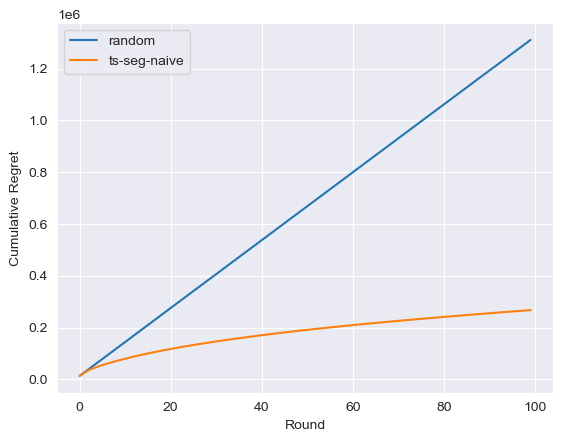

In [80]:
data_path = "results.json"

with open(data_path, 'r') as fp:
        cumulative_regrets = json.load(fp)

for k,v in mean.items():
    sns.lineplot(data = np.array(v), label=k)
    plt.fill_between(range(100), np.array(mean[k]) + np.array(std[k]),
                  np.array(mean[k]) - np.array(std[k]), alpha=0.15, color ='red')
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.show()